In [1]:
# Install missing libraries if needed
!pip install geopandas rasterio shapely





   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 82.6 MB/s eta 0:00:00:00:0100:01


In [5]:
import os
import geopandas as gpd
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import cv2
from shapely.geometry import mapping
from tqdm.notebook import tqdm
import shutil

# ------------------------
# Setup paths
# ------------------------
BASE_PATH = '/kaggle/input/spacenet-2-paris-buildings/AOI_3_Paris_Train/AOI_3_Paris_Train'
IMAGE_PATH = os.path.join(BASE_PATH, 'RGB-PanSharpen')
LABEL_PATH = os.path.join(BASE_PATH, 'geojson/buildings')

OUTPUT_IMAGE_DIR = '/kaggle/working/images'
OUTPUT_MASK_DIR = '/kaggle/working/masks'

os.makedirs(OUTPUT_IMAGE_DIR, exist_ok=True)
os.makedirs(OUTPUT_MASK_DIR, exist_ok=True)

# ------------------------
# Get file lists
# ------------------------
image_files = sorted([f for f in os.listdir(IMAGE_PATH) if f.endswith('.tif')])
geojson_files = sorted([f for f in os.listdir(LABEL_PATH) if f.endswith('.geojson')])

print("Found", len(image_files), "images")
print("Found", len(geojson_files), "geojson labels")

# ------------------------
# Process each valid pair
# ------------------------
for img_file, geojson_file in tqdm(zip(image_files, geojson_files), total=len(image_files)):
    try:
        img_path = os.path.join(IMAGE_PATH, img_file)
        geojson_path = os.path.join(LABEL_PATH, geojson_file)
        gdf = gpd.read_file(geojson_path)
        
        if gdf.empty:
            continue  # Skip images with no building polygons

        # Read image and transform
        with rasterio.open(img_path) as src:
            image = src.read([1, 2, 3]).transpose(1, 2, 0)  # RGB
            transform = src.transform

        # Save image as .png
        out_img = os.path.join(OUTPUT_IMAGE_DIR, img_file.replace('.tif', '.png'))
        cv2.imwrite(out_img, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))

        # Prepare mask
        height, width = image.shape[:2]
        mask = np.zeros((height, width), dtype=np.uint8)

        for polygon in gdf.geometry:
            if polygon.is_valid:
                if polygon.geom_type == 'Polygon':
                    coords = []
                    for coord in list(polygon.exterior.coords):
                        x, y = coord[:2]
                        row, col = ~transform * (x, y)
                        coords.append([int(col), int(row)])
                    coords = np.array(coords, dtype=np.int32)
                    cv2.fillPoly(mask, [coords], 1)

                elif polygon.geom_type == 'MultiPolygon':
                    for sub_poly in polygon.geoms:
                        coords = []
                        for coord in list(sub_poly.exterior.coords):
                            x, y = coord[:2]
                            row, col = ~transform * (x, y)
                            coords.append([int(col), int(row)])
                        coords = np.array(coords, dtype=np.int32)
                        cv2.fillPoly(mask, [coords], 1)

        # Save mask as .png
        out_mask = os.path.join(OUTPUT_MASK_DIR, img_file.replace('.tif', '.png'))
        cv2.imwrite(out_mask, mask * 255)

    except Exception as e:
        print(f"Skipping {img_file} due to error: {e}")
        continue

# ------------------------
# Zip for download
# ------------------------
shutil.make_archive('/kaggle/working/roof_images', 'zip', OUTPUT_IMAGE_DIR)
shutil.make_archive('/kaggle/working/roof_masks', 'zip', OUTPUT_MASK_DIR)

print("✅ Done. Download 'roof_images.zip' and 'roof_masks.zip' from the sidebar.")


Found 1148 images
Found 1148 geojson labels


  0%|          | 0/1148 [00:00<?, ?it/s]

✅ Done. Download 'roof_images.zip' and 'roof_masks.zip' from the sidebar.


In [15]:
class RooftopDataset(Dataset):
    def __init__(self, image_dir, mask_dir, image_transform=None, mask_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_transform = image_transform
        self.mask_transform = mask_transform

        self.image_filenames = sorted([
            f for f in os.listdir(image_dir) if f.endswith('.png')
        ])

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_name = self.image_filenames[idx]
        image_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.mask_dir, img_name)

        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.image_transform:
            image = self.image_transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        mask = (mask > 0).float()

        return image, mask



In [40]:
# --------------------------------------
# Transforms
# --------------------------------------
image_transform = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # only for images
])

mask_transform = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor()
])


In [41]:
# --------------------------------------
# Dataset & DataLoader
# --------------------------------------
dataset = RooftopDataset(
    image_dir='/kaggle/working/images',
    mask_dir='/kaggle/working/masks',
    image_transform=image_transform,
    mask_transform=mask_transform
)

from torch.utils.data import DataLoader
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

In [42]:
# --------------------------------------
# U-Net Model
# --------------------------------------
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    """[Conv2d -> BatchNorm -> ReLU] x 2"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super().__init__()

        self.down1 = DoubleConv(in_channels, 64)
        self.down2 = DoubleConv(64, 128)
        self.down3 = DoubleConv(128, 256)
        self.down4 = DoubleConv(256, 512)

        self.pool = nn.MaxPool2d(2)

        self.bottleneck = DoubleConv(512, 1024)

        self.up1 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.conv1 = DoubleConv(1024, 512)

        self.up2 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.conv2 = DoubleConv(512, 256)

        self.up3 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv3 = DoubleConv(256, 128)

        self.up4 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv4 = DoubleConv(128, 64)

        self.out_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(self.pool(d1))
        d3 = self.down3(self.pool(d2))
        d4 = self.down4(self.pool(d3))

        bn = self.bottleneck(self.pool(d4))

        up1 = self.up1(bn)
        up1 = self.conv1(torch.cat([up1, d4], dim=1))

        up2 = self.up2(up1)
        up2 = self.conv2(torch.cat([up2, d3], dim=1))

        up3 = self.up3(up2)
        up3 = self.conv3(torch.cat([up3, d2], dim=1))

        up4 = self.up4(up3)
        up4 = self.conv4(torch.cat([up4, d1], dim=1))

        return torch.sigmoid(self.out_conv(up4))  # sigmoid for binary output


In [43]:
# --------------------------------------
# Loss & IoU Metric
# --------------------------------------
def dice_loss(pred, target, smooth=1e-6):
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    return 1 - (2 * intersection + smooth) / (pred.sum() + target.sum() + smooth)

def compute_iou(pred, target):
    pred = (pred > 0.5).float()
    target = (target > 0.5).float()
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    return (intersection / union).item() if union > 0 else 0

In [44]:
# --------------------------------------
# Training Loop
# --------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
bce = nn.BCELoss()

def train_model(model, dataloader, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        total_iou = 0
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = bce(outputs, masks) + dice_loss(outputs, masks)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_iou += compute_iou(outputs, masks)

        avg_loss = total_loss / len(dataloader)
        avg_iou = total_iou / len(dataloader)
        print(f"Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.4f} | IoU: {avg_iou:.4f}")

# Run training
train_model(model, dataloader, epochs=100)


Epoch 1/100 | Loss: 1.3058 | IoU: 0.0273
Epoch 2/100 | Loss: 1.2415 | IoU: 0.0667
Epoch 3/100 | Loss: 1.2139 | IoU: 0.0878
Epoch 4/100 | Loss: 1.1955 | IoU: 0.1228
Epoch 5/100 | Loss: 1.1779 | IoU: 0.1293
Epoch 6/100 | Loss: 1.1732 | IoU: 0.1399
Epoch 7/100 | Loss: 1.1502 | IoU: 0.1647
Epoch 8/100 | Loss: 1.1361 | IoU: 0.1720
Epoch 9/100 | Loss: 1.1276 | IoU: 0.1759
Epoch 10/100 | Loss: 1.1105 | IoU: 0.1984
Epoch 11/100 | Loss: 1.1008 | IoU: 0.2019
Epoch 12/100 | Loss: 1.0886 | IoU: 0.2102
Epoch 13/100 | Loss: 1.0691 | IoU: 0.2246
Epoch 14/100 | Loss: 1.0558 | IoU: 0.2351
Epoch 15/100 | Loss: 1.0416 | IoU: 0.2428
Epoch 16/100 | Loss: 1.0263 | IoU: 0.2560
Epoch 17/100 | Loss: 1.0045 | IoU: 0.2720
Epoch 18/100 | Loss: 0.9761 | IoU: 0.2942
Epoch 19/100 | Loss: 0.9521 | IoU: 0.3085
Epoch 20/100 | Loss: 0.9204 | IoU: 0.3336
Epoch 21/100 | Loss: 0.8851 | IoU: 0.3581
Epoch 22/100 | Loss: 0.8412 | IoU: 0.3852
Epoch 23/100 | Loss: 0.7757 | IoU: 0.4297
Epoch 24/100 | Loss: 0.7382 | IoU: 0.4542
E

In [47]:
torch.save(model.state_dict(), "/kaggle/working/unet_rooftop.pth")


In [45]:
# --------------------------------------
# Prediction & Contour Visualization
# --------------------------------------
import cv2
import matplotlib.pyplot as plt
import numpy as np

def draw_outlines_on_image(image_tensor, pred_mask_tensor):
    image_np = image_tensor.permute(1, 2, 0).cpu().numpy()
    image_np = ((image_np * 0.5 + 0.5) * 255).astype(np.uint8)

    mask_np = pred_mask_tensor.squeeze().cpu().numpy().astype(np.uint8)
    contours, _ = cv2.findContours(mask_np, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    outlined = cv2.drawContours(image_np.copy(), contours, -1, (0, 255, 0), 1)

    plt.figure(figsize=(8, 8))
    plt.imshow(outlined)
    plt.title("Image with Rooftop Outlines")
    plt.axis('off')
    plt.show()

    return contours


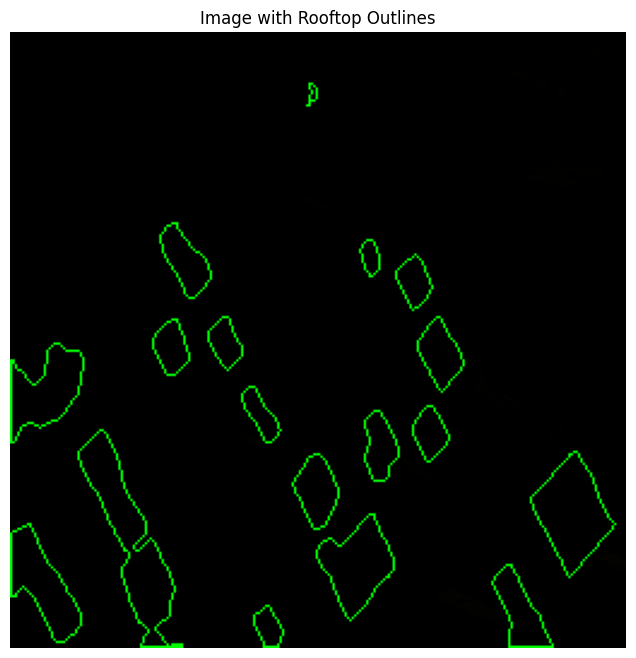

(array([[[106, 238]],
 
        [[103, 241]],
 
        [[102, 241]],
 
        [[101, 242]],
 
        [[101, 246]],
 
        [[102, 247]],
 
        [[102, 248]],
 
        [[103, 249]],
 
        [[103, 250]],
 
        [[104, 251]],
 
        [[104, 252]],
 
        [[105, 253]],
 
        [[105, 255]],
 
        [[111, 255]],
 
        [[111, 254]],
 
        [[112, 253]],
 
        [[112, 251]],
 
        [[113, 250]],
 
        [[113, 248]],
 
        [[112, 247]],
 
        [[112, 246]],
 
        [[111, 245]],
 
        [[111, 244]],
 
        [[109, 242]],
 
        [[109, 241]],
 
        [[108, 240]],
 
        [[108, 239]],
 
        [[107, 238]]], dtype=int32),
 array([[[206, 221]],
 
        [[201, 226]],
 
        [[201, 227]],
 
        [[200, 228]],
 
        [[200, 229]],
 
        [[201, 230]],
 
        [[201, 231]],
 
        [[202, 232]],
 
        [[202, 233]],
 
        [[203, 234]],
 
        [[203, 235]],
 
        [[204, 236]],
 
        [[204, 237]],
 
   

In [46]:
# Sample prediction
model.eval()
image, _ = dataset[0]
with torch.no_grad():
    pred = model(image.unsqueeze(0).to(device)).squeeze(0).squeeze(0)
    pred_bin = (pred > 0.5).float()

draw_outlines_on_image(image, pred_bin)